In [36]:
import pandas as pd
import numpy as np
import random
import ray
from itertools import combinations
import torch.nn as nn
import torch
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [3]:
####################################
## cathub
####################################

In [4]:
df_cat1 = pd.read_pickle('datasets/reactions_info_df.pickle')

In [5]:
list_scols = ['s' + str(i) for i in range(9)]
list_pcols = ['p' + str(i) for i in range(768)]
list_cols = ['sc', 'facet'] + list_scols + list_pcols + ['nre']
df_cat1 = df_cat1[list_cols]

In [6]:
df_cat1.shape

(11257, 780)

In [7]:
df_cat1.head(2)

,sc,facet,s0,s1,s2,s3,s4,s5,s6,s7,...,p759,p760,p761,p762,p763,p764,p765,p766,p767,nre
0,Ag,111,1.383361,2.22735,3.257025,1.991915,2.301531,2.101231,2.811456,0.432559,...,1.128245,0.940684,1.901682,-0.801239,-1.315113,-0.644158,0.311038,-0.162647,-0.846766,5.608979
1,Ag,111,1.383361,2.22735,3.257025,1.991915,2.301531,2.101231,2.811456,0.432559,...,0.248250,0.536033,1.534562,-0.736114,-0.747634,-1.661336,0.266347,-0.284854,-0.232635,3.996914


In [8]:
unique_groups_df_cat1 = df_cat1[['sc', 'facet']].drop_duplicates()
num_unique_groups_df_cat1 = unique_groups_df_cat1.shape[0]
print(f"Number of distinct groups for ['sc', 'facet'] in df_cat1: {num_unique_groups_df_cat1}")

Number of distinct groups for ['sc', 'facet'] in df_cat1: 1916


In [9]:
####################################
## ocp
####################################

In [10]:
df_ocp1 = pd.read_parquet('datasets/ocp_reactions_info_df.parquet')

In [11]:
df_ocp1.head(2)

,bulk_id,ads_id,bulk_mpid,bulk_symbols,ads_symbols,miller_index,shift,top,adsorption_site,class,...,p758,p759,p760,p761,p762,p763,p764,p765,p766,p767
0,2085,29,mp-976273,Hf6Ge4,*COCH2O,"[2, 1, 0]",0.022,True,"[[9.3, 4.58, 26.89]]",1,...,-0.698056,0.273536,0.742442,0.618160,0.486411,-0.934350,0.204278,0.679431,0.341144,-0.852883
1,10724,20,mp-1247259,Ca6Rh2N6,*CHCO,"[1, 0, 0]",0.312,True,"[[10.54, 1.25, 22.82]]",2,...,-0.625508,-0.456795,0.304594,1.134157,-0.394405,-1.171003,-0.648138,-0.021550,-1.443121,0.004959


In [12]:
def convert_to_int(x):
    try:
        return str(''.join(map(str, x)))
    except ValueError:
        print(f"Error with value: {x}")
        return x
    
df_ocp1.rename(columns={'energy': 'nre'}, inplace=True)
df_ocp1['miller_index'] = df_ocp1['miller_index'].apply(convert_to_int)
list_scols = ['s' + str(i) for i in range(9)]
list_pcols = ['p' + str(i) for i in range(768)]
list_cols = ['bulk_mpid', 'miller_index'] + list_scols + list_pcols + ['nre']
df_ocp1 = df_ocp1[list_cols]

In [13]:
df_ocp1.shape

(437781, 780)

In [14]:
df_ocp1.head(2)

,bulk_mpid,miller_index,s0,s1,s2,s3,s4,s5,s6,s7,...,p759,p760,p761,p762,p763,p764,p765,p766,p767,nre
0,mp-976273,210,0.008258,1.035261,1.294881,1.552592,1.783934,1.012493,2.079694,0.436319,...,0.273536,0.742442,0.618160,0.486411,-0.934350,0.204278,0.679431,0.341144,-0.852883,-9.992999
1,mp-1247259,100,0.005488,0.162778,0.328713,1.856944,1.908573,1.835093,1.429667,0.374538,...,-0.456795,0.304594,1.134157,-0.394405,-1.171003,-0.648138,-0.021550,-1.443121,0.004959,-9.982733


In [15]:
unique_groups_df_ocp1 = df_ocp1[['bulk_mpid', 'miller_index']].drop_duplicates()
num_unique_groups_df_ocp1 = unique_groups_df_ocp1.shape[0]
print(f"Number of distinct groups for ['bulk_mpid', 'miller_index'] in df_ocp1: {num_unique_groups_df_ocp1}")

Number of distinct groups for ['bulk_mpid', 'miller_index'] in df_ocp1: 91298


In [18]:
####################################
## env creation
####################################

In [22]:
## do: create env for cathub

df = df_cat1

# Create a new 'group' column in df that combines 'sc' and 'facet' 
df['group'] = list(zip(df['sc'], df['facet']))

# Find distinct groups and calculate the number of train/test groups
distinct_values_df = df[['group']].drop_duplicates().reset_index(drop=True)
list_env_group = [tuple(x) for x in distinct_values_df['group'].values]
n_env_total = len(list_env_group)
n_env_train = int(0.75 * n_env_total) # Update when necessary
train_env_groups = set(random.sample(list_env_group, n_env_train))
test_env_groups = set(list_env_group) - train_env_groups

# Create list of dataframes for each training group
list_env_train_cat1 = [df[df['group'] == grp].reset_index(drop=True) for grp in train_env_groups]

# Concatenate the list to form a single dataframe for the training set
df_train_cat1 = pd.concat(list_env_train_cat1, ignore_index=True)

# Get all the rows that don't belong to the training set groups
mask_train = df['group'].isin(train_env_groups)
df_test_cat1 = df[~mask_train].reset_index(drop=True)

# Cleanup: Drop the 'group' column as it's no longer needed
df.drop(columns=['group'], inplace=True)
df_train_cat1.drop(columns=['group'], inplace=True)
df_test_cat1.drop(columns=['group'], inplace=True)

print(len(list_env_train_cat1), len(train_env_groups), len(test_env_groups), n_env_total)
print(df_train_cat1.shape, df_test_cat1.shape, df.shape)

# Check the distinct groups
distinct_groups_train = df_train_cat1[['sc', 'facet']].drop_duplicates().reset_index(drop=True)
distinct_groups_test = df_test_cat1[['sc', 'facet']].drop_duplicates().reset_index(drop=True)
print(len(distinct_groups_train), len(distinct_groups_test))

1437 1437 479 1916
(8376, 780) (2881, 780) (11257, 780)
1437 479


In [23]:
## do: create env for ocp

df = df_ocp1

# Create a new 'group' column in df that combines 'bulk_mpid' and 'miller_index' 
df['group'] = list(zip(df['bulk_mpid'], df['miller_index']))

# Find distinct groups and calculate the number of train/test groups
distinct_values_df = df[['group']].drop_duplicates().reset_index(drop=True)
list_env_group = [tuple(x) for x in distinct_values_df['group'].values]
n_env_total = len(list_env_group)
# n_env_train = int(0.75 * n_env_total) # Update when necessary
train_env_groups = set(random.sample(list_env_group, n_env_train))
test_env_groups = set(list_env_group) - train_env_groups

# Create list of dataframes for each training group
list_env_train_ocp1 = [df[df['group'] == grp].reset_index(drop=True) for grp in train_env_groups]

# Concatenate the list to form a single dataframe for the training set
df_train_ocp1 = pd.concat(list_env_train_ocp1, ignore_index=True)

# Get all the rows that don't belong to the training set groups
mask_train = df['group'].isin(train_env_groups)
df_test_ocp1 = df[~mask_train].reset_index(drop=True)

# Cleanup: Drop the 'group' column as it's no longer needed
df.drop(columns=['group'], inplace=True)
df_train_ocp1.drop(columns=['group'], inplace=True)
df_test_ocp1.drop(columns=['group'], inplace=True)

print(len(list_env_train_ocp1), len(train_env_groups), len(test_env_groups), n_env_total)
print(df_train_ocp1.shape, df_test_ocp1.shape, df.shape)

# Check the distinct groups
distinct_groups_train = df_train_ocp1[['bulk_mpid', 'miller_index']].drop_duplicates().reset_index(drop=True)
distinct_groups_test = df_test_ocp1[['bulk_mpid', 'miller_index']].drop_duplicates().reset_index(drop=True)
print(len(distinct_groups_train), len(distinct_groups_test))

1437 1437 89861 91298
(6980, 780) (430801, 780) (437781, 780)
1437 89861


In [24]:
#############################################################################
## experiment with (cathub, ocp) X (ridge, elastic, krr, svr) X (org, pca, siamese) 
#############################################################################

In [25]:
## do: (cathub) x (ridge, elastic, krr, svr) x (org)

In [26]:
df_train_cat1.shape, df_test_cat1.shape

((8376, 780), (2881, 780))

In [27]:
df_train_cat1.head(2)

,sc,facet,s0,s1,s2,s3,s4,s5,s6,s7,...,p759,p760,p761,p762,p763,p764,p765,p766,p767,nre
0,Cd3Y,111,0.681659,0.0704,1.060865,1.422487,0.993317,1.704151,0.963178,0.27182,...,1.128245,0.940684,1.901682,-0.801239,-1.315113,-0.644158,0.311038,-0.162647,-0.846766,4.071593
1,Cd3Y,111,0.681659,0.0704,1.060865,1.422487,0.993317,1.704151,0.963178,0.27182,...,0.718674,1.495406,1.609272,-2.305226,0.098274,-1.220422,0.434692,-0.222176,-0.489837,-0.099688


In [28]:
df_test_cat1.head(2)

,sc,facet,s0,s1,s2,s3,s4,s5,s6,s7,...,p759,p760,p761,p762,p763,p764,p765,p766,p767,nre
0,AgPb,101,1.049098,1.512274,2.337853,1.97474,2.299918,2.058575,2.461176,0.366962,...,1.128245,0.940684,1.901682,-0.801239,-1.315113,-0.644158,0.311038,-0.162647,-0.846766,4.912930
1,AgPb,101,1.049098,1.512274,2.337853,1.97474,2.299918,2.058575,2.461176,0.366962,...,0.718674,1.495406,1.609272,-2.305226,0.098274,-1.220422,0.434692,-0.222176,-0.489837,0.602678


In [29]:
# Separate features and targets
X_train = df_train_cat1.iloc[:, 2:-1]
y_train = df_train_cat1.iloc[:, -1]
X_test = df_test_cat1.iloc[:, 2:-1]
y_test = df_test_cat1.iloc[:, -1]

In [31]:
# Standardize the features
scaler_X = StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)
X_test_std = scaler_X.transform(X_test)

In [33]:
# Models and hyperparameters
models = {
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10]
        }
    },
    'Elastic Regression': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'Kernel Ridge Regression': {
        'model': KernelRidge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'kernel': ['linear', 'polynomial', 'rbf'],
            'degree': [2, 3, 4]
        }
    },
    'Support Vector Regression': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['auto', 'scale']
        }
    }
}

In [37]:
# Display mean absolute value of the target
mean_absolute_target = y_test.abs().mean()
print(f"Mean Absolute Value of Target: {mean_absolute_target}")

Mean Absolute Value of Target: 1.7461732093711606


Ridge Regression Mean Absolute Error with Best Hyperparameters: 0.5820251752811255


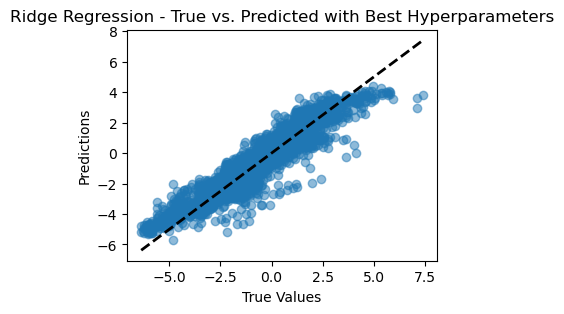

Elastic Regression Mean Absolute Error with Best Hyperparameters: 0.5919411787315711


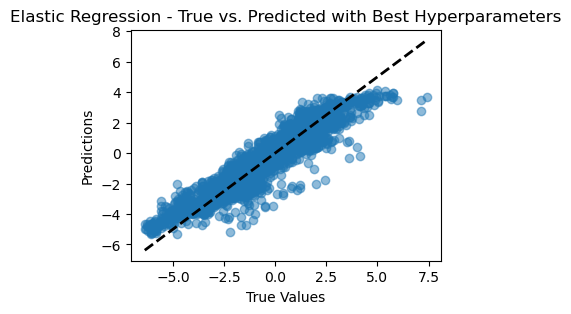

Kernel Ridge Regression Mean Absolute Error with Best Hyperparameters: 0.36697534616160593


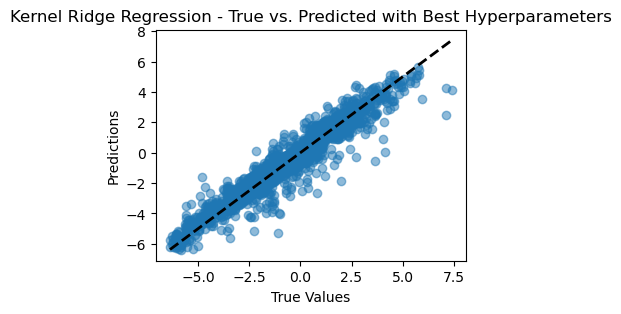

Support Vector Regression Mean Absolute Error with Best Hyperparameters: 0.37679107669903295


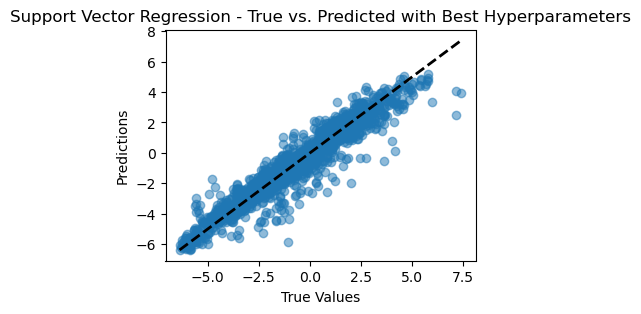

In [38]:
# Tune hyperparameters and train models
for name, model_info in models.items():
    grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring='neg_mean_absolute_error', cv=5)
    grid_search.fit(X_train_std, y_train)
    
    # Use the best model for predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_std)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} Mean Absolute Error with Best Hyperparameters: {mae}")
    
    # Plot true vs. predicted values
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"{name} - True vs. Predicted with Best Hyperparameters")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

In [44]:
## do: (ocp) x (ridge, elastic, krr, svr) x (org)

In [45]:
df_train_ocp1.shape, df_test_ocp1.shape

((6980, 780), (430801, 780))

In [46]:
df_train_ocp1.head(2)

,bulk_mpid,miller_index,s0,s1,s2,s3,s4,s5,s6,s7,...,p759,p760,p761,p762,p763,p764,p765,p766,p767,nre
0,mp-1207463,210,0.009369,0.009369,0.009369,3.116171,3.771723,2.878683,2.852399,0.615555,...,0.024781,0.165344,0.343316,-0.447962,0.978824,0.359650,1.211457,-0.227874,-0.857059,-1.397807
1,mp-1207463,210,0.009369,0.009369,0.009369,3.116171,3.771723,2.878683,2.852399,0.615555,...,-0.405270,0.720093,0.615114,-1.069989,-0.934297,-1.213113,0.018676,-0.473641,-0.320205,-0.469402


In [47]:
df_test_ocp1.head(2)

,bulk_mpid,miller_index,s0,s1,s2,s3,s4,s5,s6,s7,...,p759,p760,p761,p762,p763,p764,p765,p766,p767,nre
0,mp-976273,210,0.008258,1.035261,1.294881,1.552592,1.783934,1.012493,2.079694,0.436319,...,0.273536,0.742442,0.618160,0.486411,-0.934350,0.204278,0.679431,0.341144,-0.852883,-9.992999
1,mp-1247259,100,0.005488,0.162778,0.328713,1.856944,1.908573,1.835093,1.429667,0.374538,...,-0.456795,0.304594,1.134157,-0.394405,-1.171003,-0.648138,-0.021550,-1.443121,0.004959,-9.982733


In [48]:
# Separate features and targets
X_train = df_train_ocp1.iloc[:, 2:-1]
y_train = df_train_ocp1.iloc[:, -1]
X_test = df_test_ocp1.iloc[:, 2:-1]
y_test = df_test_ocp1.iloc[:, -1]

In [49]:
# Standardize the features
scaler_X = StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)
X_test_std = scaler_X.transform(X_test)

In [50]:
# Models and hyperparameters
models = {
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10]
        }
    },
    'Elastic Regression': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'Kernel Ridge Regression': {
        'model': KernelRidge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'kernel': ['linear', 'polynomial', 'rbf'],
            'degree': [2, 3, 4]
        }
    },
    'Support Vector Regression': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['auto', 'scale']
        }
    }
}

In [51]:
# Display mean absolute value of the target
mean_absolute_target = y_test.abs().mean()
print(f"Mean Absolute Value of Target: {mean_absolute_target}")

Mean Absolute Value of Target: 2.2789594285211634


Ridge Regression Mean Absolute Error with Best Hyperparameters: 777406.8688304534


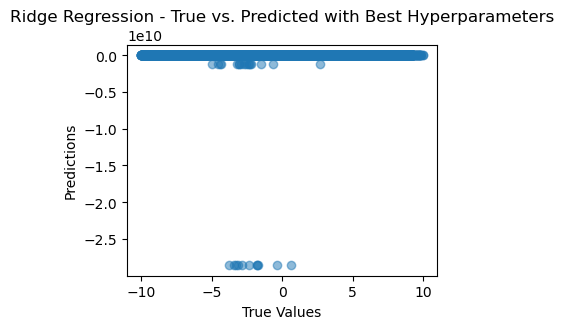

Elastic Regression Mean Absolute Error with Best Hyperparameters: 1.2858812160512003


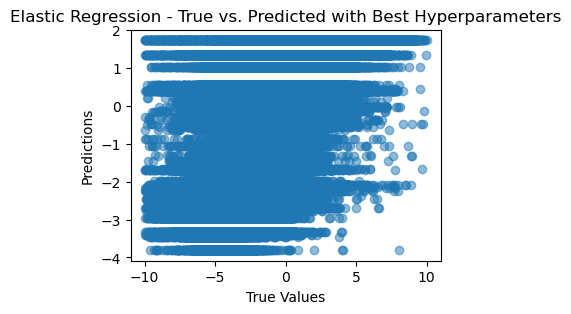

Kernel Ridge Regression Mean Absolute Error with Best Hyperparameters: 1.4957857390215572e+22


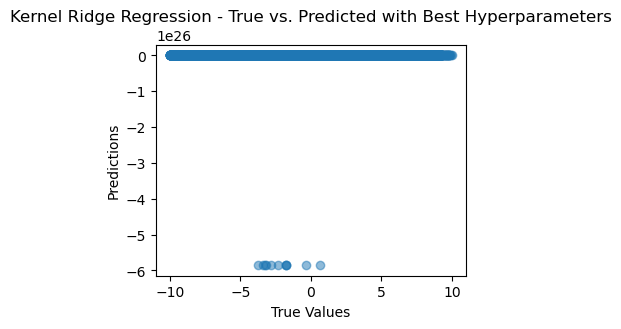

Support Vector Regression Mean Absolute Error with Best Hyperparameters: 1.2466478770620655


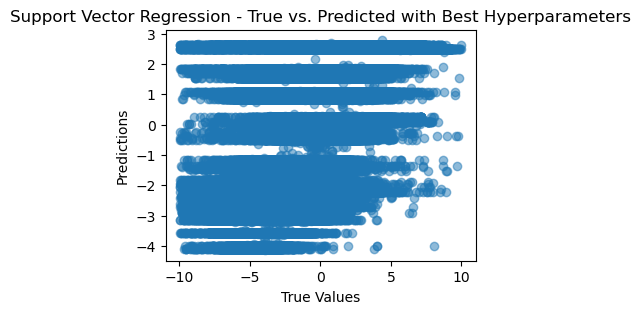

In [53]:
# Tune hyperparameters and train models
for name, model_info in models.items():
    grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring='neg_mean_absolute_error', cv=5)
    grid_search.fit(X_train_std, y_train)
    
    # Use the best model for predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_std)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} Mean Absolute Error with Best Hyperparameters: {mae}")
    
    # Plot true vs. predicted values
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"{name} - True vs. Predicted with Best Hyperparameters")
    # plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()